# Dominant color determination with a neural network

This is an experiment to see whether a NN can be trained
to determine the dominant color.  Other experiments have shown
that k-means (subjectively) gives best results.  We'll use that
as the ground truth.

## Training data

The (CIFAR10)[https://www.cs.toronto.edu/~kriz/cifar.html] dataset is pragmatic.  It is readily
available under an open license.  Images are smaller than what was used for previous tests but
this has interesting implications for performance optimization.  Let's see where this leads.

The images are normalized to [0,1].  We'll have to account for this when manipulating RGB values.
Extant labels are not useful here.  We'll have to generate labels.

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import numpy as np

def algo_sklearn(data: np.array):
    kmeans = KMeans(n_clusters=4, init='k-means++').fit(data.reshape(-1,3))
    centroids = kmeans.cluster_centers_
    return tuple(centroids[0])

def make_labels(loader):
    labels = []
    for i, data in enumerate(loader, 0):
        images, _ = data
        for image in images:
            labels += [algo_sklearn(image.permute(1, 2, 0))]
        if i % 2000 == 1999:
            print(f"{i}");
            
    return labels

transform = transforms.ToTensor()

batch_size = 10

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
train_labels = make_labels(trainloader)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
test_labels = make_labels(testloader)



# Let's put all images onto the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Initializing device data")
device_images = []
device_targets = []
index = 0
for _, data in enumerate(trainloader, 0):
    images, _ = data
    for image in images:
        device_images += [ image.to(device) ]
        device_targets += [ torch.tensor(train_labels[index], dtype=torch.float32).to(device) ]
        index += 1



Files already downloaded and verified
1999
3999
Files already downloaded and verified
Initializing device data


### Let's inspect the data

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(loader, colors, num_rows=4):

    # Show multiple rows of images with their color swatches
    images_per_row = batch_size

    # Get multiple batches of images
    dataiter = iter(loader)
    all_images = []
    for i in range(num_rows):
        images, _ = next(dataiter)
        all_images.append(images)

    # Create figure with subplots - pairs of rows for images and color swatches
    fig, axs = plt.subplots(num_rows*2, 1, figsize=(batch_size, num_rows*3), 
                            gridspec_kw={'height_ratios': [4,1]*num_rows})

    for row in range(num_rows):
        # Show images in top subplot of each pair
        img = torchvision.utils.make_grid(all_images[row], nrow=batch_size)
        npimg = img.numpy()
        axs[row*2].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[row*2].axis('off')

        # Create color swatches in bottom subplot
        start_idx = row * images_per_row
        for i in range(images_per_row):
            rect = plt.Rectangle((i/images_per_row, 0), 1/images_per_row, 1,
                            color=tuple(np.array(colors[start_idx + i]))) # / 2 + 0.5))
            axs[row*2 + 1].add_patch(rect)
        axs[row*2 + 1].set_xlim(0, 1)
        axs[row*2 + 1].set_ylim(0, 1)
        axs[row*2 + 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print labels for all shown images
    for row in range(num_rows):
        start_idx = row * images_per_row
        print(f'Row {row+1} colors:')
        print(' '.join(f'{train_labels[start_idx + i]}' for i in range(images_per_row)))
        print()


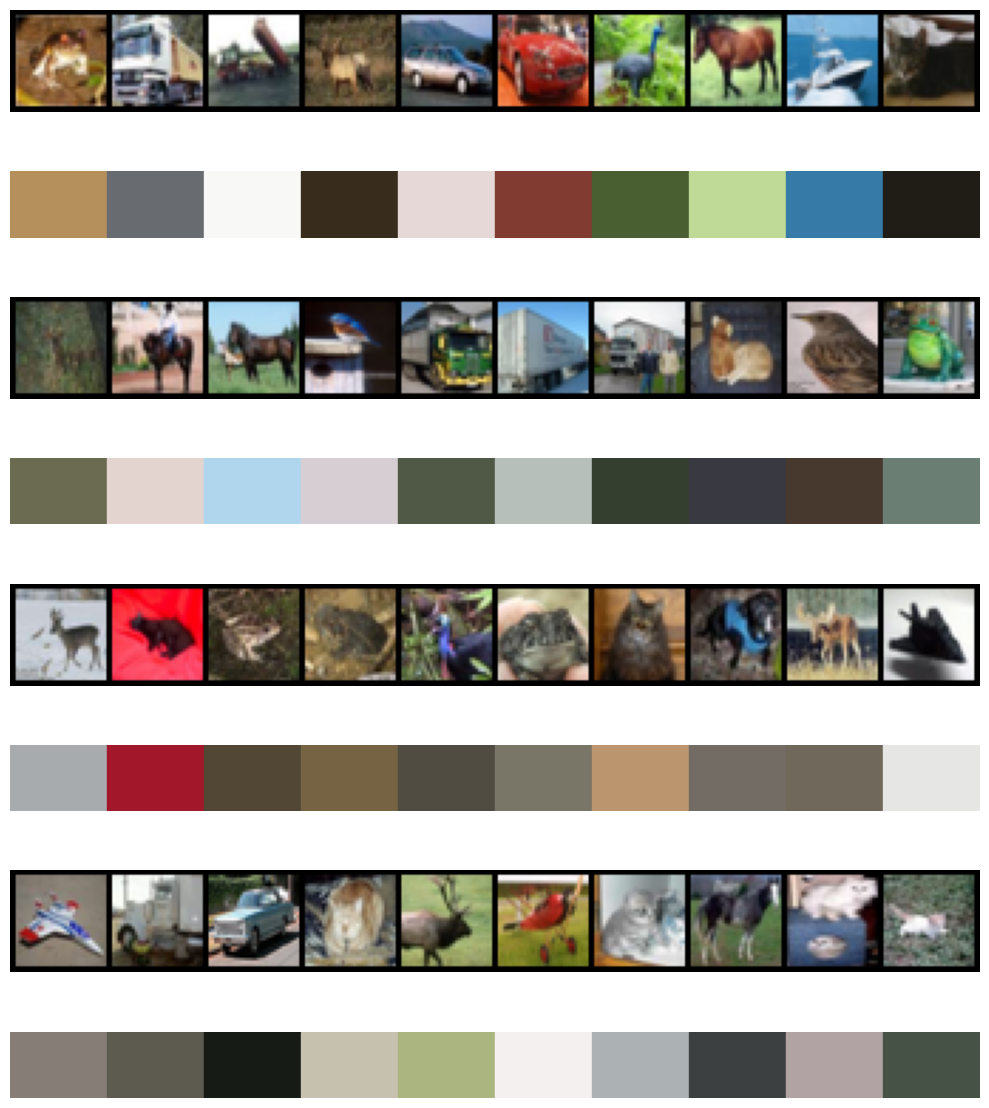

Row 1 colors:
(np.float64(0.7090284874883749), np.float64(0.5634651785179721), np.float64(0.35956575595221274)) (np.float64(0.40792210390103745), np.float64(0.4177128648597922), np.float64(0.43872879175531787)) (np.float64(0.9739539445003617), np.float64(0.973697393297035), np.float64(0.9681754340635282)) (np.float64(0.21894317692787635), np.float64(0.17689155111626043), np.float64(0.11086740145870184)) (np.float64(0.9020308181643486), np.float64(0.8477591127157211), np.float64(0.8396358639001846)) (np.float64(0.50560151384427), np.float64(0.2315285861175952), np.float64(0.191771992173451)) (np.float64(0.28448060853737045), np.float64(0.37083855606879745), np.float64(0.19536921715509173)) (np.float64(0.7494568246844653), np.float64(0.8546502471372888), np.float64(0.5889904853459951)) (np.float64(0.21243006780092394), np.float64(0.4821311670587731), np.float64(0.6571399958703695)) (np.float64(0.12740315955418807), np.float64(0.113261968428601), np.float64(0.08657617188333122))

Row 2 co

In [25]:
display_images(trainloader, train_labels)

# Set up a Neural Network

The k-means algorithm that was used to determine the ground truth does not consider spacial data, just pixel values.
Intuitively there does not seem to be any reason to use a CNN.  However it seems plausible that like colors are clustered.  This implies that a CNN might help.

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class ColorNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: [3, 32, 32] (single image, no batch dimension)
        
        # Add convolutional layer to detect color patterns
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        
        # First reduce spatial dimensions while keeping color information
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        
        # Flatten spatial dimensions
        self.flatten = nn.Flatten(start_dim=0)
        
        # Reduce to RGB through fully connected layers
        self.fc1 = nn.Linear(12 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 3)  # Final output is RGB values
        
        # Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Input: [3, 32, 32]
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output: [3] (RGB values)
        return x

MODEL_PATH = './dc_net.pth'

## Train

In [36]:
import random

net = ColorNet()
net.to(device)

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

EPOCHS=5

assert(len(device_images) == len(device_targets))

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"Epoch {epoch + 1}")

    running_loss = 0.0
    index = 0
    train_input = list(range(len(device_images)))
    random.shuffle(train_input)
    for i in train_input:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(device_images[i])
        
        # Convert tuple label to tensor
        loss = criterion(outputs, device_targets[i])
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        index += 1
        
        if index % 10000 == 9999:
            print(f'[{epoch + 1}, {index + 1:5d}] loss: {running_loss / 10000:.3f}')
            running_loss = 0.0

print('Finished Training')
# torch.cuda.empty_cache()

Epoch 1
[1, 10000] loss: 0.046
[1, 20000] loss: 0.042
[1, 30000] loss: 0.041
[1, 40000] loss: 0.042
[1, 50000] loss: 0.041
Epoch 2
[2, 10000] loss: 0.041
[2, 20000] loss: 0.041
[2, 30000] loss: 0.041
[2, 40000] loss: 0.041
[2, 50000] loss: 0.042
Epoch 3
[3, 10000] loss: 0.041
[3, 20000] loss: 0.041
[3, 30000] loss: 0.042
[3, 40000] loss: 0.041
[3, 50000] loss: 0.041
Epoch 4
[4, 10000] loss: 0.040
[4, 20000] loss: 0.041
[4, 30000] loss: 0.042
[4, 40000] loss: 0.041
[4, 50000] loss: 0.041
Epoch 5
[5, 10000] loss: 0.041
[5, 20000] loss: 0.041
[5, 30000] loss: 0.041
[5, 40000] loss: 0.041
[5, 50000] loss: 0.041
Finished Training


## Save and Restore

In [37]:
torch.save(net.state_dict(), MODEL_PATH)

In [38]:
net = ColorNet().to(device)
net.load_state_dict(torch.load(MODEL_PATH, weights_only=True))

<All keys matched successfully>

## Apply the network to the test data

In [39]:

criterion = nn.MSELoss(reduction="mean")
test_actuals = []
index = 0
running_loss = 0.0
for i, data in enumerate(testloader, 0):
    images, _ = data
    for image in images:
        image = image.to(device)
        actual =  net(image)
        target = torch.tensor(test_labels[index], dtype=torch.float32).to(device)
        loss = criterion(actual, target)
        running_loss += loss.item()
        test_actuals += [ actual.cpu().detach().numpy() ]
        index += 1
        
print(f"Test loss: {running_loss / index}")
    

Test loss: 0.04141221573581788


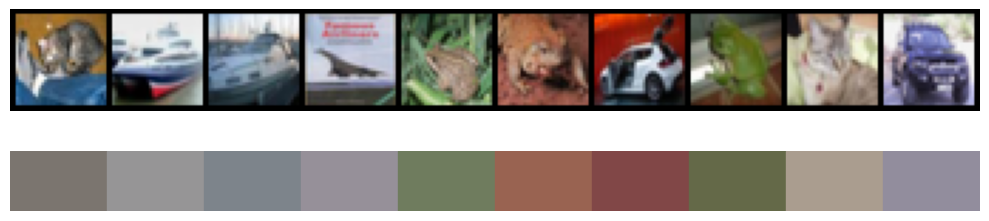

Row 1 colors:
(np.float64(0.7090284874883749), np.float64(0.5634651785179721), np.float64(0.35956575595221274)) (np.float64(0.40792210390103745), np.float64(0.4177128648597922), np.float64(0.43872879175531787)) (np.float64(0.9739539445003617), np.float64(0.973697393297035), np.float64(0.9681754340635282)) (np.float64(0.21894317692787635), np.float64(0.17689155111626043), np.float64(0.11086740145870184)) (np.float64(0.9020308181643486), np.float64(0.8477591127157211), np.float64(0.8396358639001846)) (np.float64(0.50560151384427), np.float64(0.2315285861175952), np.float64(0.191771992173451)) (np.float64(0.28448060853737045), np.float64(0.37083855606879745), np.float64(0.19536921715509173)) (np.float64(0.7494568246844653), np.float64(0.8546502471372888), np.float64(0.5889904853459951)) (np.float64(0.21243006780092394), np.float64(0.4821311670587731), np.float64(0.6571399958703695)) (np.float64(0.12740315955418807), np.float64(0.113261968428601), np.float64(0.08657617188333122))



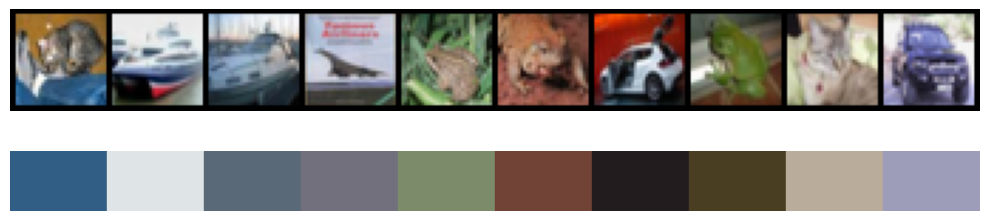

Row 1 colors:
(np.float64(0.7090284874883749), np.float64(0.5634651785179721), np.float64(0.35956575595221274)) (np.float64(0.40792210390103745), np.float64(0.4177128648597922), np.float64(0.43872879175531787)) (np.float64(0.9739539445003617), np.float64(0.973697393297035), np.float64(0.9681754340635282)) (np.float64(0.21894317692787635), np.float64(0.17689155111626043), np.float64(0.11086740145870184)) (np.float64(0.9020308181643486), np.float64(0.8477591127157211), np.float64(0.8396358639001846)) (np.float64(0.50560151384427), np.float64(0.2315285861175952), np.float64(0.191771992173451)) (np.float64(0.28448060853737045), np.float64(0.37083855606879745), np.float64(0.19536921715509173)) (np.float64(0.7494568246844653), np.float64(0.8546502471372888), np.float64(0.5889904853459951)) (np.float64(0.21243006780092394), np.float64(0.4821311670587731), np.float64(0.6571399958703695)) (np.float64(0.12740315955418807), np.float64(0.113261968428601), np.float64(0.08657617188333122))



In [40]:
display_images(testloader, test_actuals, num_rows=1)
display_images(testloader, test_labels, num_rows=1)

## Computational Performance

On my hardware performance on CPU beats out the GPU.  Most likely this is due to the expense
of sending the image to the GPU and then retrieving the results from the GPU.  This adds latency.

On CPU all cores are consumed.  This may have performance impact on other running tasks.  However,
likely there is impact when running on GPU as well.

### On Device

In [47]:
import time


net = ColorNet().to(device)
net.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
index = 0
start = time.time()
for i, data in enumerate(testloader, 0):
    images, _ = data
    for image in images:
        image = image.to(device)
        # Need to include effort to get data off device
        actual = net(image).cpu().detach().numpy()
        index += 1
end = time.time()
        
print(f"On device performance: {index / (end - start)} inference / second")

On device performance: 2257.9905889423653 inference / second


### On CPU

In [48]:
import time


net = ColorNet()
net.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
index = 0
start = time.time()
for i, data in enumerate(testloader, 0):
    images, _ = data
    for image in images:
        # Need to include effort to get data off device
        actual = net(image)
        index += 1
end = time.time()
        
print(f"On CPU performance: {index / (end - start)} inference / second")

On CPU performance: 4813.48522829633 inference / second
